#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Exploring the TF-Hub CORD-19 Swivel Embeddings


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/cord_19_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The CORD-19 Swivel text embedding module from TF-Hub (https://tfhub.dev/tensorflow/cord-19/swivel-128d/1)
 was built to support researchers analyzing natural languages text related to COVID-19.
These embeddings were trained on the titles, authors, abstracts, body texts, and
reference titles of articles in the [CORD-19 dataset](https://api.semanticscholar.org/CorpusID:216056360).

In this colab we will:
- Analyze semantically similar words in the embedding space
- Train a classifier on the SciCite dataset using the CORD-19 embeddings


## Setup


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity('ERROR')

import tensorflow_datasets as tfds
import tensorflow_hub as hub

try:
  from google.colab import data_table
  def display_df(df):
    return data_table.DataTable(df, include_index=False)
except ModuleNotFoundError:
  # If google-colab is not available, just display the raw DataFrame
  def display_df(df):
    return df

2022-12-14 13:17:11.613975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:17:11.614081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:17:11.614090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Analyze the embeddings

Let's start off by analyzing the embedding by calculating and plotting a correlation matrix between different terms. If the embedding learned to successfully capture the meaning of different words, the embedding vectors of semantically similar words should be close together. Let's take a look at some COVID-19 related terms.

2022-12-14 13:17:13.443325: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


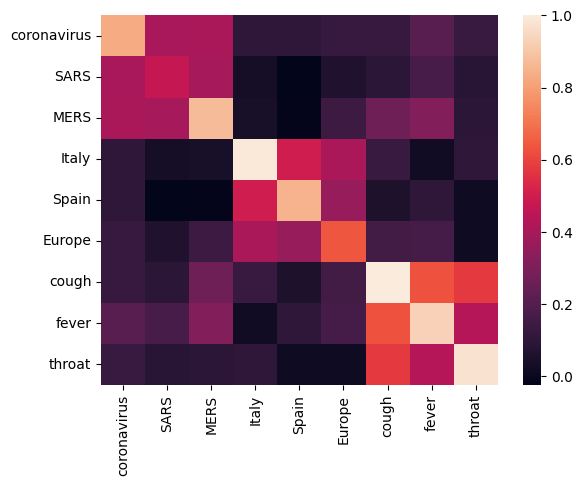

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)


with tf.Graph().as_default():
  # Load the module
  query_input = tf.placeholder(tf.string)
  module = hub.Module('https://tfhub.dev/tensorflow/cord-19/swivel-128d/1')
  embeddings = module(query_input)

  with tf.train.MonitoredTrainingSession() as sess:

    # Generate embeddings for some terms
    queries = [
        # Related viruses
        "coronavirus", "SARS", "MERS",
        # Regions
        "Italy", "Spain", "Europe",
        # Symptoms
        "cough", "fever", "throat"
    ]

    features = sess.run(embeddings, feed_dict={query_input: queries})
    plot_correlation(queries, features)

We can see that the embedding successfully captured the meaning of the different terms. Each word is similar to the other words of its cluster (i.e. "coronavirus" highly correlates with "SARS" and "MERS"), while they are different from terms of other clusters (i.e. the similarity between "SARS" and "Spain" is close to 0).

Now let's see how we can use these embeddings to solve a specific task.

## SciCite: Citation Intent Classification

This section shows how one can use the embedding for downstream tasks such as text classification. We'll use the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) from TensorFlow Datasets to classify citation intents in academic papers. Given a sentence with a citation from an academic paper, classify whether the main intent of the citation is as background information, use of methods, or comparing results.

In [4]:
#@title Set up the dataset from TFDS

class Dataset:
  """Build a dataset from a TFDS dataset."""
  def __init__(self, tfds_name, feature_name, label_name):
    self.dataset_builder = tfds.builder(tfds_name)
    self.dataset_builder.download_and_prepare()
    self.feature_name = feature_name
    self.label_name = label_name
  
  def get_data(self, for_eval):
    splits = THE_DATASET.dataset_builder.info.splits
    if tfds.Split.TEST in splits:
      split = tfds.Split.TEST if for_eval else tfds.Split.TRAIN
    else:
      SPLIT_PERCENT = 80
      split = "train[{}%:]".format(SPLIT_PERCENT) if for_eval else "train[:{}%]".format(SPLIT_PERCENT)
    return self.dataset_builder.as_dataset(split=split)

  def num_classes(self):
    return self.dataset_builder.info.features[self.label_name].num_classes

  def class_names(self):
    return self.dataset_builder.info.features[self.label_name].names

  def preprocess_fn(self, data):
    return data[self.feature_name], data[self.label_name]

  def example_fn(self, data):
    feature, label = self.preprocess_fn(data)
    return {'feature': feature, 'label': label}, label


def get_example_data(dataset, num_examples, **data_kw):
  """Show example data"""
  with tf.Session() as sess:
    batched_ds = dataset.get_data(**data_kw).take(num_examples).map(dataset.preprocess_fn).batch(num_examples)
    it = tf.data.make_one_shot_iterator(batched_ds).get_next()
    data = sess.run(it)
  return data


TFDS_NAME = 'scicite' #@param {type: "string"}
TEXT_FEATURE_NAME = 'string' #@param {type: "string"}
LABEL_NAME = 'label' #@param {type: "string"}
THE_DATASET = Dataset(TFDS_NAME, TEXT_FEATURE_NAME, LABEL_NAME)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES = 20  #@param {type:"integer"}
data = get_example_data(THE_DATASET, NUM_EXAMPLES, for_eval=False)
display_df(
    pd.DataFrame({
        TEXT_FEATURE_NAME: [ex.decode('utf8') for ex in data[0]],
        LABEL_NAME: [THE_DATASET.class_names()[x] for x in data[1]]
    }))

string       label
0   The finding that BMI is closely related to TBF...      result
1   The average magnitude of the NBR increases wit...  background
2   It has been reported that NF-κB activation can...      result
3   , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4   5B), but, interestingly, they shared conserved...  background
5   Some investigators have noted an association o...  background
6   In our previous study, it is documented that b...  background
7   These subjects have intact cognitive function ...  background
8   Another study reported improved knee function ...  background
9   C. Data Analysis Transcription Speech samples ...      method
10  o) was administered 14 days after the inductio...      method
11  showed that individuals who had previously exp...      result
12  However, a more stringent microarray experimen...  background
13  These results, of a fast short term depression...      result
14  The proportion of laboratory confirmed cases (...  background
15  Scientometric studies employing bibliometric a...      method
16  Our choice of studying CFI in higher detail is...  background
17  5 mg), GST-53BP2(715-1005) (1 mg), GST-GL(1-25...  background
18  DCS is preferable to External Storage (ES) at ...  background
19  RDo, where RD, RF and RDo represent relative d...      method

## Training a citaton intent classifier

We'll train a classifier on the [SciCite dataset](https://www.tensorflow.org/datasets/catalog/scicite) using an Estimator. Let's set up the input_fns to read the dataset into the model

In [6]:
def preprocessed_input_fn(for_eval):
  data = THE_DATASET.get_data(for_eval=for_eval)
  data = data.map(THE_DATASET.example_fn, num_parallel_calls=1)
  return data


def input_fn_train(params):
  data = preprocessed_input_fn(for_eval=False)
  data = data.repeat(None)
  data = data.shuffle(1024)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_eval(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.repeat(1)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_predict(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.batch(batch_size=params['batch_size'])
  return data

Let's build a model which use the CORD-19 embeddings with a classification layer on top.

In [7]:
def model_fn(features, labels, mode, params):
  # Embed the text
  embed = hub.Module(params['module_name'], trainable=params['trainable_module'])
  embeddings = embed(features['feature'])

  # Add a linear layer on top
  logits = tf.layers.dense(
      embeddings, units=THE_DATASET.num_classes(), activation=None)
  predictions = tf.argmax(input=logits, axis=1)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'logits': logits,
            'predictions': predictions,
            'features': features['feature'],
            'labels': features['label']
        })
  
  # Set up a multi-class classification head
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
  loss = tf.reduce_mean(loss)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    precision = tf.metrics.precision(labels=labels, predictions=predictions)
    recall = tf.metrics.recall(labels=labels, predictions=predictions)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        })


In [8]:
#@title Hyperparmeters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/1'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}
STEPS =   8000#@param {type: "integer"}
EVAL_EVERY = 200  #@param {type: "integer"}
BATCH_SIZE = 10  #@param {type: "integer"}
LEARNING_RATE = 0.01  #@param {type: "number"}

params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'module_name': EMBEDDING,
    'trainable_module': TRAINABLE_MODULE
}

## Train and evaluate the model

Let's train and evaluate the model to see the performance on the SciCite task

In [9]:
estimator = tf.estimator.Estimator(functools.partial(model_fn, params=params))
metrics = []

for step in range(0, STEPS, EVAL_EVERY):
  estimator.train(input_fn=functools.partial(input_fn_train, params=params), steps=EVAL_EVERY)
  step_metrics = estimator.evaluate(input_fn=functools.partial(input_fn_eval, params=params))
  print('Global step {}: loss {:.3f}, accuracy {:.3f}'.format(step, step_metrics['loss'], step_metrics['accuracy']))
  metrics.append(step_metrics)

2022-12-14 13:17:18.608727: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_82254/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


2022-12-14 13:17:20.267388: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 0: loss 0.805, accuracy 0.673


2022-12-14 13:17:21.578882: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:23.130041: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 200: loss 0.709, accuracy 0.737


2022-12-14 13:17:24.039425: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:25.420241: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 400: loss 0.665, accuracy 0.751


2022-12-14 13:17:26.350485: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:27.689877: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 600: loss 0.650, accuracy 0.747


2022-12-14 13:17:28.631305: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:29.956245: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 800: loss 0.624, accuracy 0.770


2022-12-14 13:17:30.865582: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:32.199344: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1000: loss 0.608, accuracy 0.771


2022-12-14 13:17:33.109644: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:34.629701: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1200: loss 0.602, accuracy 0.771


2022-12-14 13:17:35.579652: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:36.885602: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1400: loss 0.595, accuracy 0.772


2022-12-14 13:17:37.808432: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:39.100259: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1600: loss 0.590, accuracy 0.770


2022-12-14 13:17:40.033136: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:41.326140: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1800: loss 0.586, accuracy 0.775


2022-12-14 13:17:42.234369: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:43.573459: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2000: loss 0.578, accuracy 0.780


2022-12-14 13:17:44.523910: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:45.878334: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2200: loss 0.578, accuracy 0.772


2022-12-14 13:17:46.794796: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:48.083793: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2400: loss 0.567, accuracy 0.788


2022-12-14 13:17:48.989880: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:50.334086: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2600: loss 0.570, accuracy 0.776


2022-12-14 13:17:51.258123: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:52.623831: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2800: loss 0.569, accuracy 0.777


2022-12-14 13:17:53.561873: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:54.974251: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3000: loss 0.556, accuracy 0.792


2022-12-14 13:17:55.901999: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:57.212540: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3200: loss 0.557, accuracy 0.787


2022-12-14 13:17:58.141921: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:17:59.779189: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3400: loss 0.558, accuracy 0.780


2022-12-14 13:18:00.883698: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:02.185680: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3600: loss 0.551, accuracy 0.791


2022-12-14 13:18:03.124206: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:04.422033: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3800: loss 0.552, accuracy 0.789


2022-12-14 13:18:05.320345: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:06.614288: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4000: loss 0.561, accuracy 0.777


2022-12-14 13:18:07.515576: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:08.759732: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4200: loss 0.551, accuracy 0.785


2022-12-14 13:18:09.678704: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:10.946382: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4400: loss 0.558, accuracy 0.777


2022-12-14 13:18:11.872005: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:13.209142: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4600: loss 0.558, accuracy 0.772


2022-12-14 13:18:14.122017: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:15.466316: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4800: loss 0.547, accuracy 0.787


2022-12-14 13:18:16.373200: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:17.641901: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5000: loss 0.549, accuracy 0.789


2022-12-14 13:18:18.559729: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:19.888893: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5200: loss 0.542, accuracy 0.790


2022-12-14 13:18:20.794698: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:22.126832: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5400: loss 0.550, accuracy 0.788


2022-12-14 13:18:23.012987: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:24.336729: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5600: loss 0.546, accuracy 0.784


2022-12-14 13:18:25.570025: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:26.913488: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5800: loss 0.545, accuracy 0.784


2022-12-14 13:18:27.815429: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:29.076040: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6000: loss 0.541, accuracy 0.789


2022-12-14 13:18:29.997144: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:31.386816: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6200: loss 0.553, accuracy 0.775


2022-12-14 13:18:32.291647: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:33.555454: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6400: loss 0.546, accuracy 0.787


2022-12-14 13:18:34.496894: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:35.804268: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6600: loss 0.541, accuracy 0.790


2022-12-14 13:18:36.731427: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:38.103627: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6800: loss 0.538, accuracy 0.789


2022-12-14 13:18:39.004639: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:40.282839: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7000: loss 0.542, accuracy 0.784


2022-12-14 13:18:41.203176: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:42.534588: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7200: loss 0.537, accuracy 0.789


2022-12-14 13:18:43.479215: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:44.775580: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7400: loss 0.542, accuracy 0.785


2022-12-14 13:18:45.694676: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:47.028380: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7600: loss 0.543, accuracy 0.786


2022-12-14 13:18:47.928337: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 13:18:49.191316: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7800: loss 0.537, accuracy 0.790


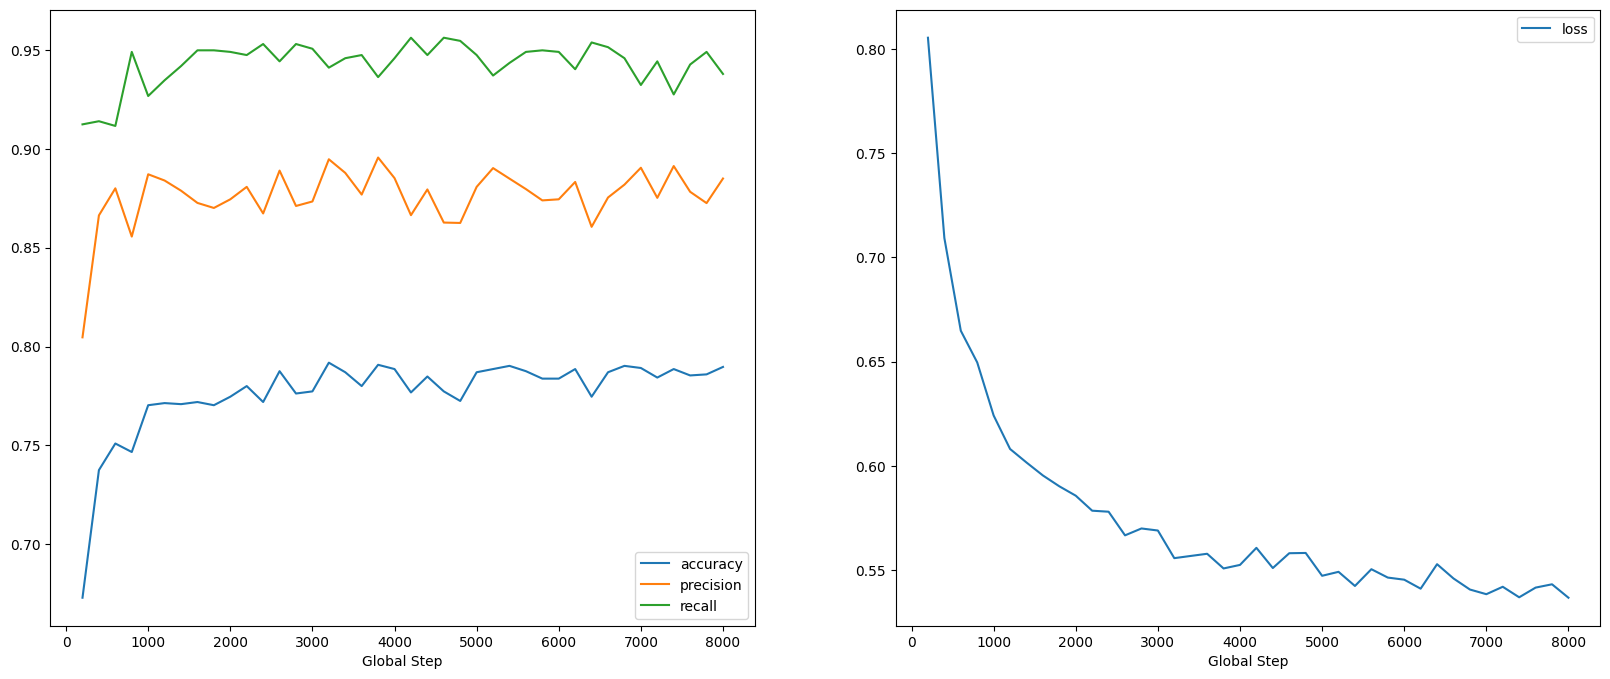

In [10]:
global_steps = [x['global_step'] for x in metrics]
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

for axes_index, metric_names in enumerate([['accuracy', 'precision', 'recall'],
                                            ['loss']]):
  for metric_name in metric_names:
    axes[axes_index].plot(global_steps, [x[metric_name] for x in metrics], label=metric_name)
  axes[axes_index].legend()
  axes[axes_index].set_xlabel("Global Step")

We can see that the loss quickly decreases while especially the accuracy rapidly increases. Let's plot some examples to check how the prediction relates to the true labels:

In [11]:
predictions = estimator.predict(functools.partial(input_fn_predict, params))

In [12]:
first_10_predictions = list(itertools.islice(predictions, 10))

display_df(
  pd.DataFrame({
      TEXT_FEATURE_NAME: [pred['features'].decode('utf8') for pred in first_10_predictions],
      LABEL_NAME: [THE_DATASET.class_names()[pred['labels']] for pred in first_10_predictions],
      'prediction': [THE_DATASET.class_names()[pred['predictions']] for pred in first_10_predictions]
  }))

2022-12-14 13:18:50.725415: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_82254/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


string       label  prediction
0  The diffraction grating, LED, and split detect...  background      method
1  Our ideas are based on a previous paper [4] de...  background      method
2  Our finding is consistent with the literature ...      result      result
3  Test scores from each of the cognitive domains...      method      method
4  The optimization algorithm was set to maximize...      method      method
5  To quantify the extent of substitution saturat...      method      method
6  Examples of gesture control are based on the e...      method      method
7  The identification of these features has been ...      method      result
8  Postulated mechanisms for observed effects of ...  background  background
9  The right inferior phrenic artery is the most ...  background  background

We can see that for this random sample, the model predicts the correct label most of the times, indicating that it can embed scientific sentences pretty well.

# What's next?

Now that you've gotten to know a bit more about the CORD-19 Swivel embeddings from TF-Hub, we encourage you to participate in the CORD-19 Kaggle competition to contribute to gaining scientific insights from COVID-19 related academic texts.

* Participate in the [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
* Learn more about the [COVID-19 Open Research Dataset (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
* See documentation and more about the TF-Hub embeddings at https://tfhub.dev/tensorflow/cord-19/swivel-128d/1
* Explore the CORD-19 embedding space with the [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/1/tensorboard/full_projector_config.json)